# 1. Import

In [2]:
import numpy as np

In [10]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
import random
from tqdm.notebook import tqdm
import json

# 2. Keypoints using Mediapipe Hands and Pose

In [2]:
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils # drawing utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

1


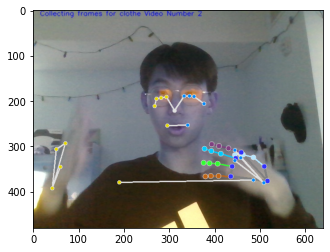

In [6]:
# Test
with mp_hands.Hands(model_complexity=0,min_detection_confidence=0.3,min_tracking_confidence=0.5) as hands:
    with mp_pose.Pose(min_detection_confidence=0.4,min_tracking_confidence=0.4) as pose:

        image = cv2.imread("test.jpg")
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        results_pose = pose.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for i in range(len(results.multi_hand_landmarks)):
                mp_drawing.draw_landmarks(image,results.multi_hand_landmarks[i],mp_hands.HAND_CONNECTIONS,mp_drawing_styles.get_default_hand_landmarks_style(),mp_drawing_styles.get_default_hand_connections_style())

        mp_drawing.draw_landmarks(image,results_pose.pose_landmarks,mp_pose.POSE_CONNECTIONS,landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        plt.imshow(image)       

# 3. Extract Keypoints Values

In [7]:
def extract_keypoints(image,hands,pose):
    results = hands.process(image)
    results_pose = pose.process(image)

    hand_np = []
    if results.multi_hand_landmarks:
        for i in range(len(results.multi_hand_landmarks)):
            hand_np.append(np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[i].landmark]).flatten() if results.multi_hand_landmarks[i] else np.zeros(21*3))

    if len(hand_np) == 0:
        lh = np.zeros(21*3)
        rh = np.zeros(21*3)
    elif len(hand_np) == 1:
        lh = hand_np[0]
        rh = np.zeros(21*3)
    else:
        lh = hand_np[0]
        rh = hand_np[1]        
    ps = np.array([[res.x, res.y, res.z, res.visibility] for res in results_pose.pose_landmarks.landmark]).flatten() if results_pose.pose_landmarks else np.zeros(33*4)

    return np.concatenate([ps, lh, rh])

In [8]:
def extract_keypoints_aug(image,hands,pose,xval,yval):
    results = hands.process(image)
    results_pose = pose.process(image)

    hand_np = []
    if results.multi_hand_landmarks:
        for i in range(len(results.multi_hand_landmarks)):
            hand_np.append(np.array([[res.x+xval, res.y+yval, res.z] if res.x != 0 and res.y!= 0 else [res.x, res.y, res.z] for res in results.multi_hand_landmarks[i].landmark]).flatten() if results.multi_hand_landmarks[i].landmark else np.zeros(21*3))
    if len(hand_np) == 0:
        lh = np.zeros(21*3)
        rh = np.zeros(21*3)
    elif len(hand_np) == 1:
        lh = hand_np[0]
        rh = np.zeros(21*3)
    else:
        lh = hand_np[0]
        rh = hand_np[1]    
    ps = np.array([[res.x+xval, res.y+yval, res.z, res.visibility] if res.x != 0 and res.y!= 0 else [res.x, res.y, res.z, res.visibility] for res in results_pose.pose_landmarks.landmark]).flatten() if results_pose.pose_landmarks else np.zeros(33*4)

    return np.concatenate([ps, lh, rh])

In [49]:
result_test = extract_keypoints(results)

In [53]:
result_test_aug = extract_keypoints_aug(results, random.uniform(0.01,0.05),random.uniform(0.01,0.05))

# 4. Setup

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data_MSASL_test') 
SAVE_PATH = os.path.join('keypoints_noface_msasl_test')

In [10]:
action = json.load(open(os.path.join("MSASL","MSASL_classes.json")))

In [11]:
action.sort()

In [21]:
os.makedirs(SAVE_PATH,exist_ok=True)
for act in action:
    os.makedirs(os.path.join(SAVE_PATH, act),exist_ok=True)

# 5. Extract Keypoints & Augment for Collected dataset

In [ ]:
for label in tqdm(action):
    LABEL_PATH = os.path.join(DATA_PATH,label)
    if os.path.exists(LABEL_PATH):
        for video in os.listdir(LABEL_PATH):
            for frame in os.listdir(os.path.join(LABEL_PATH,video)):
                if frame.endswith('.jpg'):
                    # print(f'Reading {os.path.join(LABEL_PATH,video,frame)}...')
                    
                    npy_path_prev = os.path.join(SAVE_PATH,label,video+"_"+frame.replace(".jpg", "")+".npy")
                    if(os.path.exists(npy_path_prev)):
                        continue
                        
                    # Capture video
                    image = cv2.imread(os.path.join(LABEL_PATH,video,frame))
                    # Set mediapipe model 
                    with mp_hands.Hands(min_detection_confidence=0.3,min_tracking_confidence=0.3) as hands:
                        with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
                            
                            
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                            image.flags.writeable = False
                            
                            # Make detections
                            keypoints_flipped = extract_keypoints(cv2.flip(image,1), hands, pose)
                            keypoints = extract_keypoints(image, hands, pose)
                            
                            image.flags.writeable = True
                            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                            
                            # Export keypoints & augment
                            npy_path = os.path.join(SAVE_PATH,label,video+"_"+frame.replace(".jpg", "")+".npy")

                            np.save(npy_path, keypoints)

                            keypoints_aug = extract_keypoints_aug(image,hands,pose,random.uniform(0.01,0.03),random.uniform(0.01,0.03))
                            npy_path_aug = os.path.join(SAVE_PATH,label,video+"_"+frame.replace(".jpg", "")+"_AUG.npy")
                            np.save(npy_path_aug, keypoints_aug)

                            npy_path_flipped = os.path.join(SAVE_PATH,label,video+"_"+frame.replace(".jpg", "")+"_MIR.npy")
                            np.save(npy_path_flipped, keypoints_flipped)                   

# 6. Preprocess Data and Create Labels and Features

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(action)}
print(label_map)

In [ ]:
sequences, labels = [], []
for act in tqdm(label_map.keys()):
    if os.path.exists(os.path.join('keypoints_noface_msasl_val', act)):
        if len(os.listdir(os.path.join('keypoints_noface_msasl_val', act))) == 0:
            continue
        sequence_max = np.max(np.array([int(name.split("_")[0]) for name in os.listdir(os.path.join('keypoints_noface_msasl_val', act))]))
        
        for sequence in range(0,sequence_max+1):
            window = []
            last_frame = 0
            if len([int(name.split("_")[1].replace(".npy",'')) for name in os.listdir(os.path.join('keypoints_noface_msasl_val', act)) if int(name.split("_")[0]) == sequence]) == 0:
                print("ACT:",act,"SEQ:",sequence)
                continue
            frame_max = np.max(np.array([int(name.split("_")[1].replace(".npy",'')) for name in os.listdir(os.path.join('keypoints_noface_msasl_val', act)) if int(name.split("_")[0]) == sequence]))
            for frame_num in range(0,frame_max+1,1):
                if os.path.exists(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}.npy".format(frame_num))): 
                    res = np.load(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}.npy".format(frame_num)))
                    last_frame = frame_num
                else: # if the video length is shorter than sequence length, need to pad
                    print("NO FRAME ERROR for frame num",frame_num,"SEQ",sequence,"OF ACTION",act)
                    # res = np.zeros((1662,),dtype='float64') # zero padding
                    # res = np.load(os.path.join('keypoints_noface_msasl_train', act, str(sequence)+"_"+"{}.npy".format(last_frame))) # last frame padding
                window.append(res)
                
            # repeat for aug and mir
            window_aug = []
            last_frame = 0
            for frame_num in range(0,frame_max+1,1):
                if os.path.exists(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}_AUG.npy".format(frame_num))): 
                    res = np.load(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}_AUG.npy".format(frame_num)))
                    last_frame = frame_num
                else: 
                    print("NO FRAME ERROR AUG for frame num",frame_num,"SEQ",sequence,"OF ACTION",act)
                    # res = np.load(os.path.join(SAVE_PATH, act, str(sequence)+"_"+"{}_AUG.npy".format(last_frame))) # last frame padding
                window_aug.append(res)
                       
            window_mir = []
            last_frame = 0
            for frame_num in range(0,frame_max+1,1):
                if os.path.exists(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}_MIR.npy".format(frame_num))): 
                    res = np.load(os.path.join('keypoints_noface_msasl_val', act, str(sequence)+"_"+"{}_MIR.npy".format(frame_num)))
                    last_frame = frame_num
                else: 
                    print("NO FRAME ERROR MIR for frame num",frame_num,"SEQ",sequence,"OF ACTION",act)
                    # res = np.load(os.path.join(SAVE_PATH, act, str(sequence)+"_"+"{}_MIR.npy".format(last_frame))) # last frame padding
                window_mir.append(res)

            sequences.append(window)
            labels.append(label_map[act])
            sequences.append(window_aug)
            labels.append(label_map[act])
            sequences.append(window_mir)
            labels.append(label_map[act])

In [ ]:
X = np.array(sequences)

In [63]:
y = to_categorical(labels,num_classes=len(action)).astype(int)
y = np.argmax(y, axis=1).reshape(-1, 1)

In [64]:
info = [len(y[y==i]) for i in range(len(action))]

In [ ]:
print(info)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [59]:
info = [len(y_test[y_test==i]) for i in range(len(action))]

In [66]:
os.makedirs("transformer_data"+"noface_msasl100",exist_ok=True)
np.save(os.path.join("transformer_data"+"noface_msasl100","X_val.npy"),X)
np.save(os.path.join("transformer_data"+"noface_msasl100","y_val.npy"),y)

In [14]:
X_train = np.load(os.path.join("transformer_data"+"noface_msasl100","X_val.npy"),allow_pickle=True)

In [15]:
X_train_pad = np.zeros((len(X_train),128,258))

In [17]:
for i in range(len(X_train)):
    # X_new[i]
    for j in range(min(len(X_train[i]),128)):
        X_train_pad[i][j] = X_train[i][j]

In [19]:
np.save(os.path.join("transformer_data"+"noface_msasl100","X_val_pad.npy"),X_train_pad)

In [2]:
X_train = np.load(os.path.join("transformer_data"+"noface_msasl100","X_train_pad.npy"))
X_test = np.load(os.path.join("transformer_data"+"noface_msasl100","X_test_pad.npy"))
X_val = np.load(os.path.join("transformer_data"+"noface_msasl100","X_val_pad.npy"))

y_train = np.load(os.path.join("transformer_data"+"noface_msasl100","y_train.npy"))
y_test = np.load(os.path.join("transformer_data"+"noface_msasl100","y_test.npy"))
y_val = np.load(os.path.join("transformer_data"+"noface_msasl100","y_val.npy"))

In [ ]:
X = np.load(os.path.join("transformer_data"+"noface_msasl100","X_val.npy"),allow_pickle=True)

seq = []
for i in range(len(X)):
    print(i,"/",len(X))
    window = []
    for j in range(len(X[i])):
        frame = X[i][j]
        frame = frame.astype("float16")
        window.append(frame)
    seq.append(window)
    
np.save(os.path.join("transformer_data"+"noface_msasl100","X_val_float16.npy"),seq)

In [19]:
X = np.concatenate((np.load(os.path.join("transformer_data"+"noface_msasl100","X_train_float16.npy"),allow_pickle=True),np.load(os.path.join("transformer_data"+"noface_msasl100","X_test_float16.npy"),allow_pickle=True),np.load(os.path.join("transformer_data"+"noface_msasl100","X_val_float16.npy"),allow_pickle=True)),axis=0)
y = np.concatenate((np.load(os.path.join("transformer_data"+"noface_msasl100","y_train.npy")),np.load(os.path.join("transformer_data"+"noface_msasl100","y_test.npy")),np.load(os.path.join("transformer_data"+"noface_msasl100","y_val.npy"))),axis=0)

In [20]:
print(X.shape)
print(y.shape)

(53865,)
(53865, 1)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [24]:
np.save(os.path.join("transformer_data"+"noface_msasl100","X_train_split.npy"),X_train)
np.save(os.path.join("transformer_data"+"noface_msasl100","X_test_split.npy"),X_test)
np.save(os.path.join("transformer_data"+"noface_msasl100","y_train_split.npy"),y_train)
np.save(os.path.join("transformer_data"+"noface_msasl100","y_test_split.npy"),y_test)
